<a href="https://colab.research.google.com/github/v-zeng/python_projects/blob/main/tf_audio_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Deep Audio Classifier with Tensorflow
### Data from: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

In [1]:
# # 1. install dependencies
!pip install Tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.35.0
    Uninstalling tensorflow-io-gcs-filesystem-0.35.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.35.0


In [2]:
# load dependencies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
# define path to data files
capuchin_file = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
not_capuchin_file = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [4]:
not_capuchin_file

'/content/drive/MyDrive/python_projects_data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [5]:
# 2. create function to load data and convert to 16Hz mono channel
# code below references tensorflow docs
def load_wav_16k_mono(filename):
  # load encoded wav file
  file_contents = tf.io.read_file(filename)
  # decode wav, mono channel
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # removes trailing axis, cast sample rate as 64 bit int for resampling
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # goes from 44100Hz to 16000Hz - amplitude of the audio signal
  # reduces amount of data processing required
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

In [6]:
# load the two waves defined in paths above
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(not_capuchin_file)

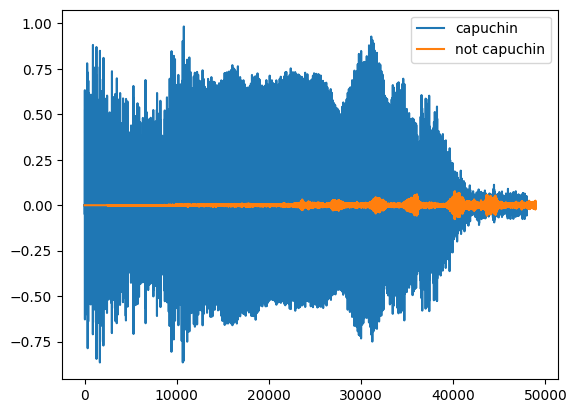

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.legend(['capuchin', 'not capuchin'])
plt.show()

In [8]:
# 3. Create Tensorflow Dataset
# define positive and negative data paths
POS = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Not_Capuchinbird_Clips')
# create Tensorflow format Dataset from any wav files
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [9]:
# inspect first item in iterator; check next filepath
pos.as_numpy_iterator().next()

b'/content/drive/MyDrive/python_projects_data/Parsed_Capuchinbird_Clips/XC216012-0.wav'

In [10]:
# label and combine samples accordingly, 1 for pos and 0 for neg
# note: pos (217) and neg (593) samples unbalanced, consider resample or undersample of neg
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [11]:
# shuffle combined data and check for binary label
for i in range(10):
  print((data.shuffle(500).as_numpy_iterator().next()[1]))

1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0


In [12]:
# 4. Determine mean event length (capuchin call)
# convert samples to 16kmono wav form
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips', file))
  lengths.append(len(tensor_wave))


In [13]:
# check filepath
print(os.listdir(os.path.join('/content/drive/MyDrive/python_projects_data', 'Parsed_Capuchinbird_Clips'))[1:50:10])


['XC114132-6.wav', 'XC114132-3.wav', 'XC114132-4.wav', 'XC16803-1.wav', 'XC216012-13.wav']


In [14]:
# check mean of parsed cap samples, calculate capuchin clip length mean

mean_length = tf.math.reduce_mean(lengths)/16000 # 54156
min_length = tf.math.reduce_min(lengths)/16000 # 32000
max_length = tf.math.reduce_max(lengths)/16000 # 80000
print(f'''
mean length: {mean_length}
min length: {min_length}
max length: {max_length}''')


mean length: 3.38475
min length: 2.0
max length: 5.0


In [15]:
# 5. Create function for converting data to spectrograms; preprocessing
def preprocess(file_path, label): # label will be passed through
  wav = load_wav_16k_mono(file_path) # convert data to desired wav form
  wav = wav[:48000] # use 48k sizing for each signal]
  # zero padding for sub-48k clips
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  # short-time Fourier transformation
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram) # convert to absolute values
  # add single channel for use with CNN
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [16]:
# test function
wav = load_wav_16k_mono(capuchin_file)
wav = wav[:48000] # use 48k sizing for each signal]
# zero padding for sub-48k clips
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav], 0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

In [17]:
# test function cont'd 1 - spectrogram conversion
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram) # convert to absolute values
spectrogram = tf.expand_dims(spectrogram, axis=2) # add single channel

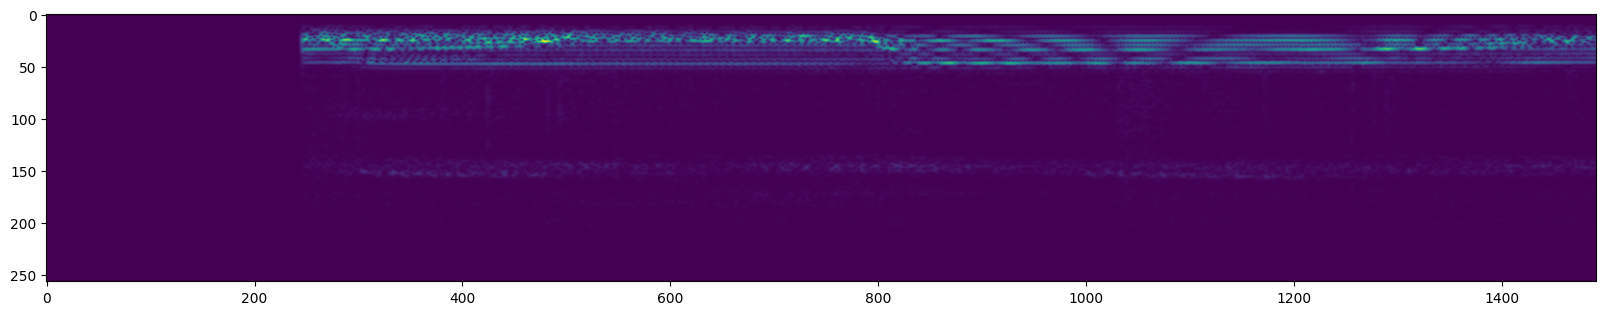

In [18]:
# test function cont'd 2 - view spectrogram
# get next positive example from pipeline
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(20,15))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

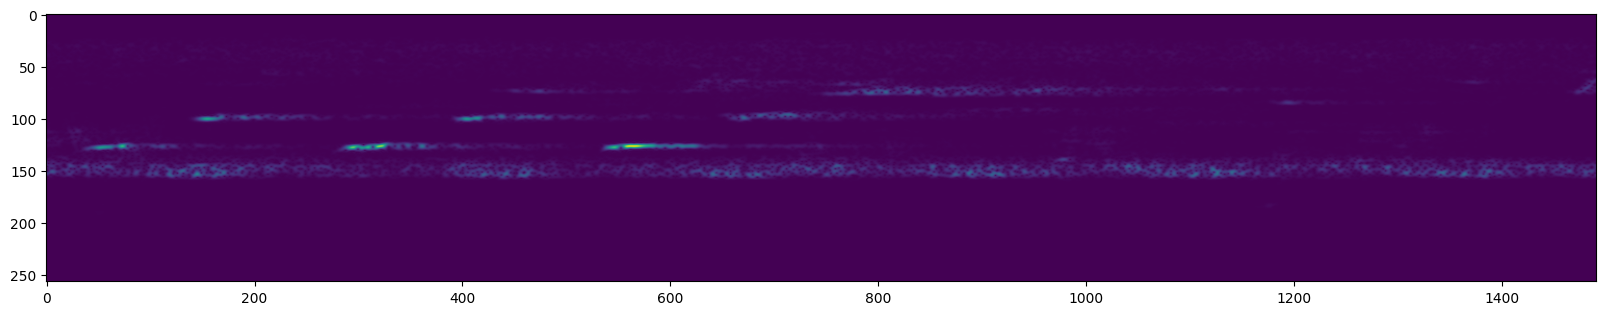

In [19]:
# take a look at negative example from pipeline
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(20,15))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [20]:
# 6. Train test partitioning
# create tensorflow data pipeline
data = data.map(preprocess) # map preprocess function across elements
data = data.cache() # cache elements in dataset
data = data.shuffle(buffer_size=1000) # random shuffle elements
data = data.batch(16) # combine elements, 16 samples per batch
data = data.prefetch(8) # prefetch 8 examples to mitigate bottlenecking

In [21]:
# train test split (75/25)
total_samples = len(data) # 51
train_size = round(total_samples*0.75) # 38
test_size = total_samples-train_size # 13
train = data.take(train_size) # take 75% of data for train
test = data.skip(train_size).take(test_size) # skip 75% taken for train, 25% remaining is test

In [22]:
# test single batch
samples, labels = train.as_numpy_iterator().next() # batch size defined as 16 above

In [23]:
print(samples.shape) # (16, 1491, 257, 1)
print(labels) # [1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]

(16, 1491, 257, 1)
[0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]


In [33]:
# 7. Build model for deep learning
# import tf dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [65]:
# build sequential model
tf.keras.backend.clear_session() # release global state, clear clutter from multiple model runs
model = Sequential() # instantiate
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1))) # input shape previously defined, 2D convolution layer with 32 output filters, a 3x3 kernel size, rectified linear unit
model.add(MaxPooling2D((2,2))) # downsample, 2x2 pool_size
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten()) # flatten to single dim
model.add(Dense(128, activation='relu')) # first layer, densely-connected 128 units
model.add(Dropout(0.2)) # randomly drop nodes at rate of 0.2, prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) #

In [66]:
# compile model
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [68]:
# fit model, list successive losses and metrics
epochs=10 # 10 cycles through training data, 1 cycle = fwd and back pass
history = model.fit(train, epochs=epochs,validation_data=test)

Epoch 1/10
38/38 [==============================] - 6s 98ms/step - loss: 0.6898 - recall: 0.8313 - precision: 0.8263 - val_loss: 0.1582 - val_recall: 1.0000 - val_precision: 0.9508
Epoch 2/10
38/38 [==============================] - 4s 111ms/step - loss: 0.0669 - recall: 0.9688 - precision: 0.9748 - val_loss: 0.0195 - val_recall: 0.9808 - val_precision: 1.0000
Epoch 3/10
38/38 [==============================] - 4s 96ms/step - loss: 0.0237 - recall: 0.9941 - precision: 1.0000 - val_loss: 0.0116 - val_recall: 1.0000 - val_precision: 0.9828
Epoch 4/10
38/38 [==============================] - 4s 93ms/step - loss: 0.0165 - recall: 0.9937 - precision: 0.9937 - val_loss: 0.0024 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
38/38 [==============================] - 3s 88ms/step - loss: 0.0075 - recall: 0.9937 - precision: 0.9937 - val_loss: 7.8095e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
38/38 [==============================] - 4s 95ms/step - loss: 0.0058 - recall: 

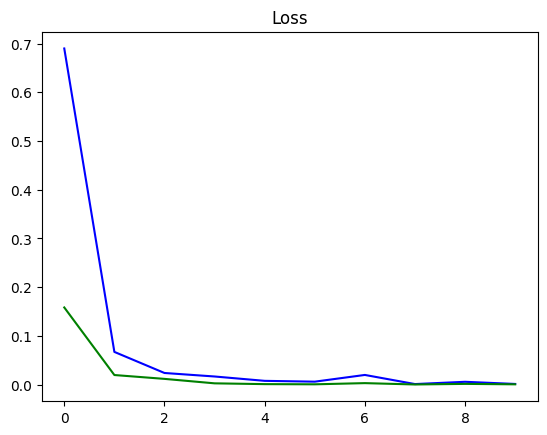

In [69]:
# visualize loss
plt.title('Loss')
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.show()

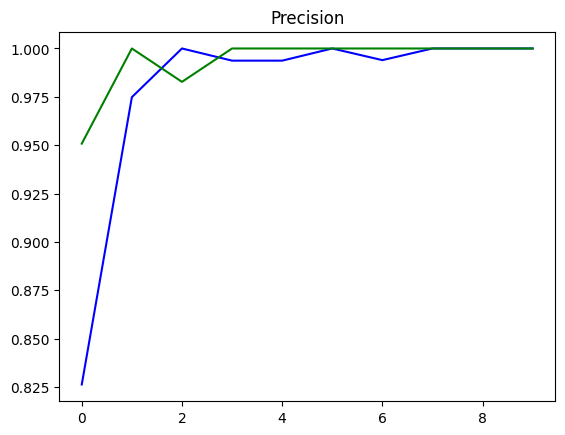

In [70]:
# visualize precision
plt.title('Precision')
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.show()

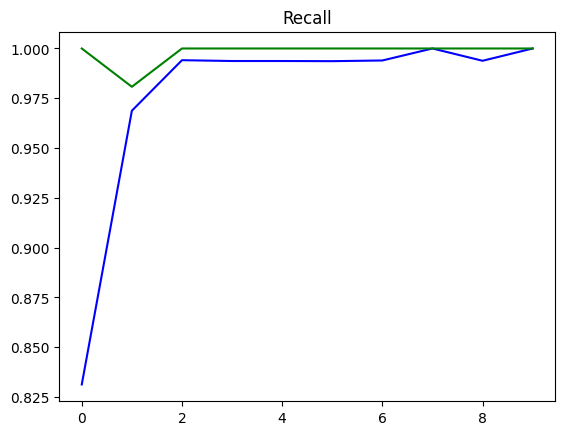

In [75]:
# visualize recall
plt.title('Recall')
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])
